In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import torch
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print('Device is', device)

from inference.path import LinearConditionalProbabilityPath
from inference.distribution import CheckerboardSampleable, CirclesSampleable, Gaussian
from learning.train import ConditionalFlowMatchingTrainer
from learning.mlp import MLPVectorField
from inference.ode import LearnedVectorFieldODE
from inference.simulator import EulerSimulator, record_every

import matplotlib.pyplot as plt

Device is mps


In [3]:
from typing import Optional
import numpy as np
from matplotlib.axes import Axes
import matplotlib.cm as cm

def hist2d_samples(samples, ax: Optional[Axes] = None, bins: int = 200, scale: float = 5.0, percentile: int = 99, **kwargs):
    H, xedges, yedges = np.histogram2d(samples[:, 0], samples[:, 1], bins=bins, range=[[-scale, scale], [-scale, scale]])

    # Determine color normalization based on the 99th percentile
    cmax = np.percentile(H, percentile)
    cmin = 0.0
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

    # Plot using imshow for more control
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(H.T, extent=extent, origin='lower', norm=norm, **kwargs)

# Bridging Flow Model

In [4]:
# Construct conditional probability path
path = LinearConditionalProbabilityPath(
    p_simple = CirclesSampleable(device),
    p_data = CheckerboardSampleable(device, grid_size=4)
).to(device)

# Construct learnable vector field
bridging_flow_model = MLPVectorField(dim=2, hiddens=[100,100,100,100])

# Construct trainer
trainer = ConditionalFlowMatchingTrainer(path, bridging_flow_model, device)
losses = trainer.train(num_epochs=20000, lr=1e-3, batch_size=2000)

Training: Epoch 450, loss: 0.1127:   2%|▏         | 481/20000 [00:04<03:06, 104.39it/s]


KeyboardInterrupt: 

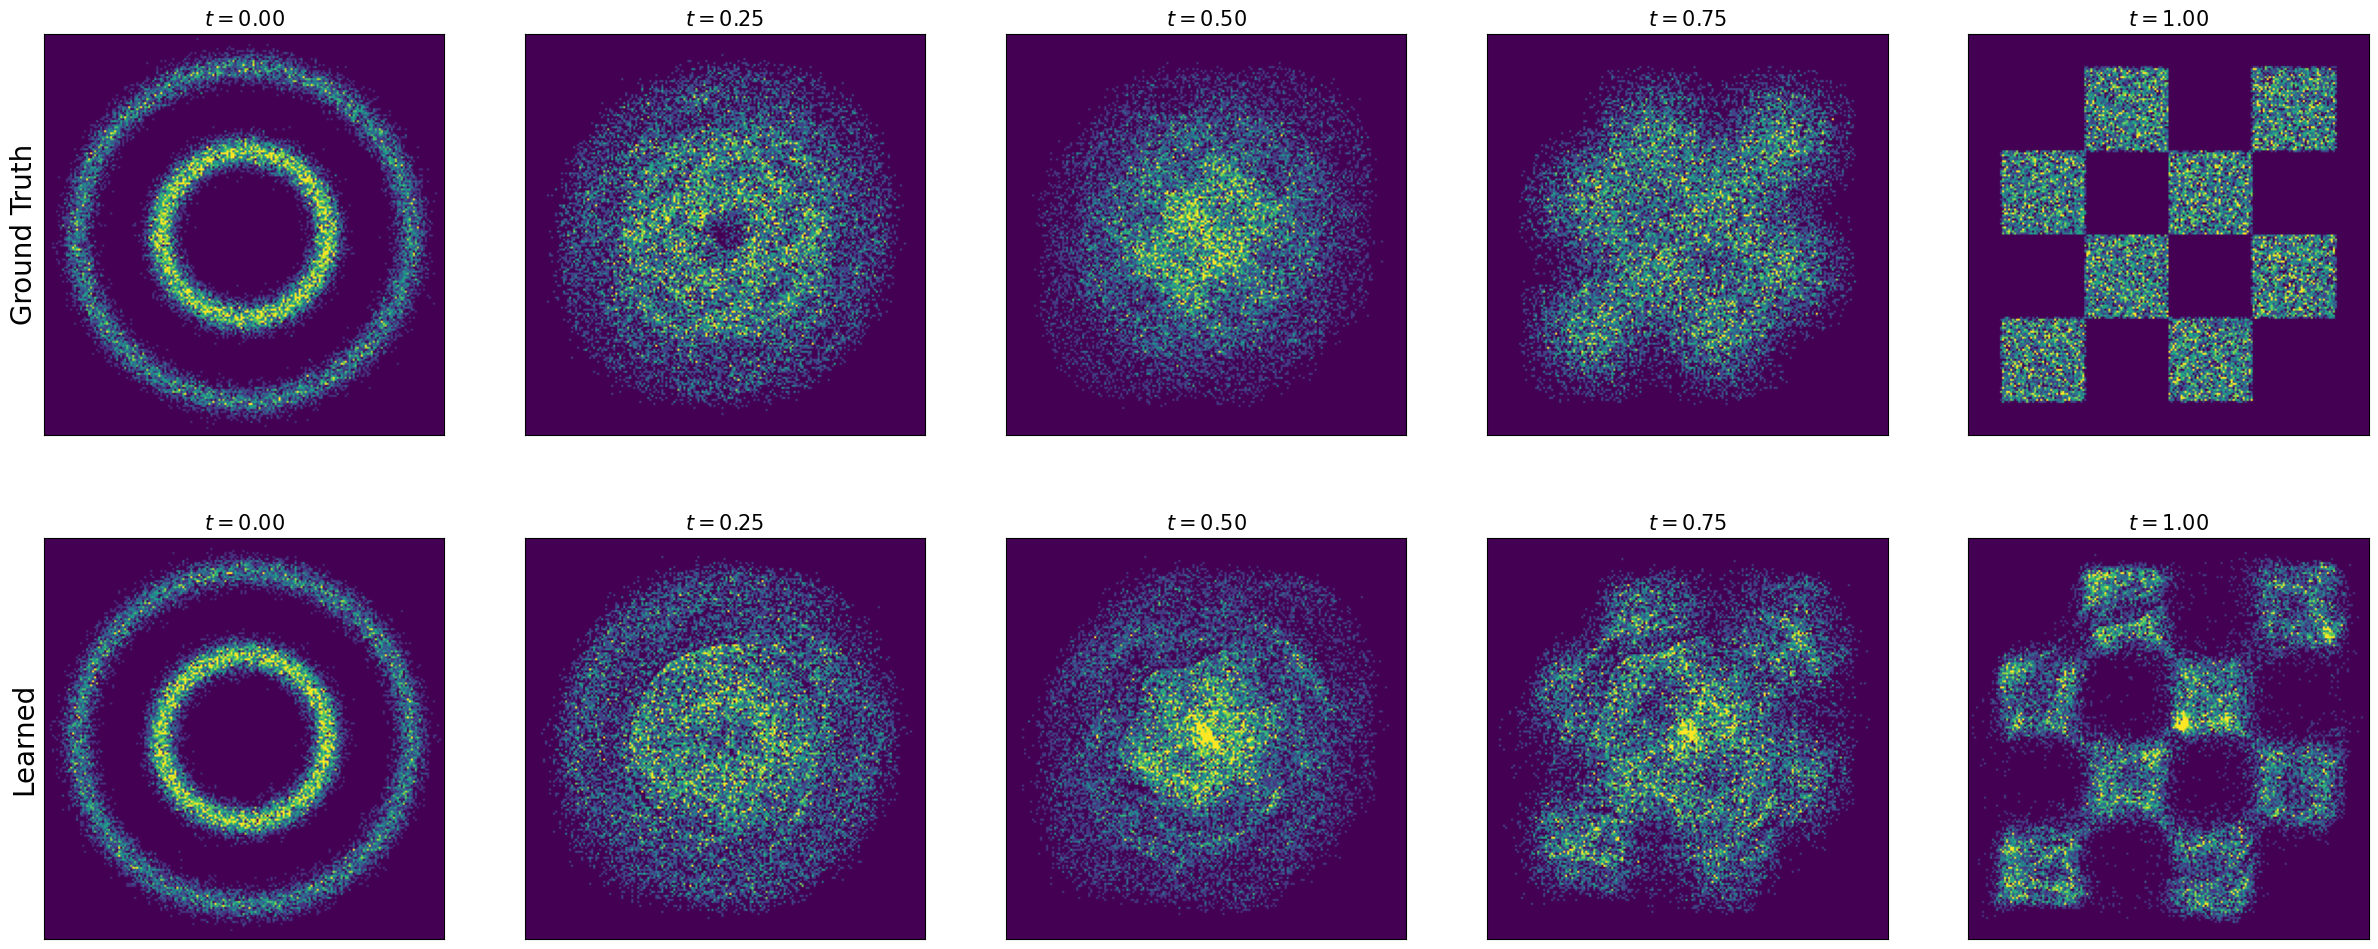

In [11]:
##########################
# Play around With These #
##########################
num_samples = 30000
num_marginals = 5


##############
# Setup Plots #
##############

fig, axes = plt.subplots(2, num_marginals, figsize=(6 * num_marginals, 6 * 2))
axes = axes.reshape(2, num_marginals)
scale = 6.0


###########################
# Graph Ground-Truth Marginals #
###########################
ts = torch.linspace(0.0, 1.0, num_marginals).to(device)
for idx, t in enumerate(ts):
    tt = t.view(1,1).expand(num_samples,1)
    xts = path.sample_marginal_path(tt)
    hist2d_samples(samples=xts.cpu(), ax=axes[0, idx], bins=200, scale=scale, percentile=99, alpha=1.0)
    axes[0, idx].set_xlim(-scale, scale)
    axes[0, idx].set_ylim(-scale, scale)
    axes[0, idx].set_xticks([])
    axes[0, idx].set_yticks([])
    axes[0, idx].set_title(f'$t={t.item():.2f}$', fontsize=15)
axes[0, 0].set_ylabel("Ground Truth", fontsize=20)

###############################################
# Graph Learned Marginals #
###############################################
ode = LearnedVectorFieldODE(bridging_flow_model)
simulator = EulerSimulator(ode)
ts = torch.linspace(0,1,200).to(device)
record_every_idxs = record_every(len(ts), len(ts) // (num_marginals - 1))
x0 = path.p_simple.sample(num_samples)
xts = simulator.simulate_with_trajectory(x0, ts.view(1,-1,1).expand(num_samples,-1,1))
xts = xts[:,record_every_idxs,:]
for idx in range(xts.shape[1]):
    xx = xts[:,idx,:]
    hist2d_samples(samples=xx.cpu(), ax=axes[1, idx], bins=200, scale=scale, percentile=99, alpha=1.0)
    axes[1, idx].set_xlim(-scale, scale)
    axes[1, idx].set_ylim(-scale, scale)
    axes[1, idx].set_xticks([])
    axes[1, idx].set_yticks([])
    tt = ts[record_every_idxs[idx]]
    axes[1, idx].set_title(f'$t={tt.item():.2f}$', fontsize=15)
axes[1, 0].set_ylabel("Learned", fontsize=20)

plt.show()

# Linear Flow Model

In [18]:
# Construct conditional probability path
path = LinearConditionalProbabilityPath(
    p_simple = Gaussian.isotropic(dim=2, std=1.0),
    p_data = CheckerboardSampleable(device, grid_size=4)
).to(device)

# Construct learnable vector field
linear_flow_model = MLPVectorField(dim=2, hiddens=[64,64,64,64])

# Construct trainer
trainer = ConditionalFlowMatchingTrainer(path, linear_flow_model, device)
losses = trainer.train(num_epochs=10000, lr=1e-3, batch_size=2000)

Epoch 9999, loss: 0.06440075486898422: : 10000it [01:48, 92.14it/s]


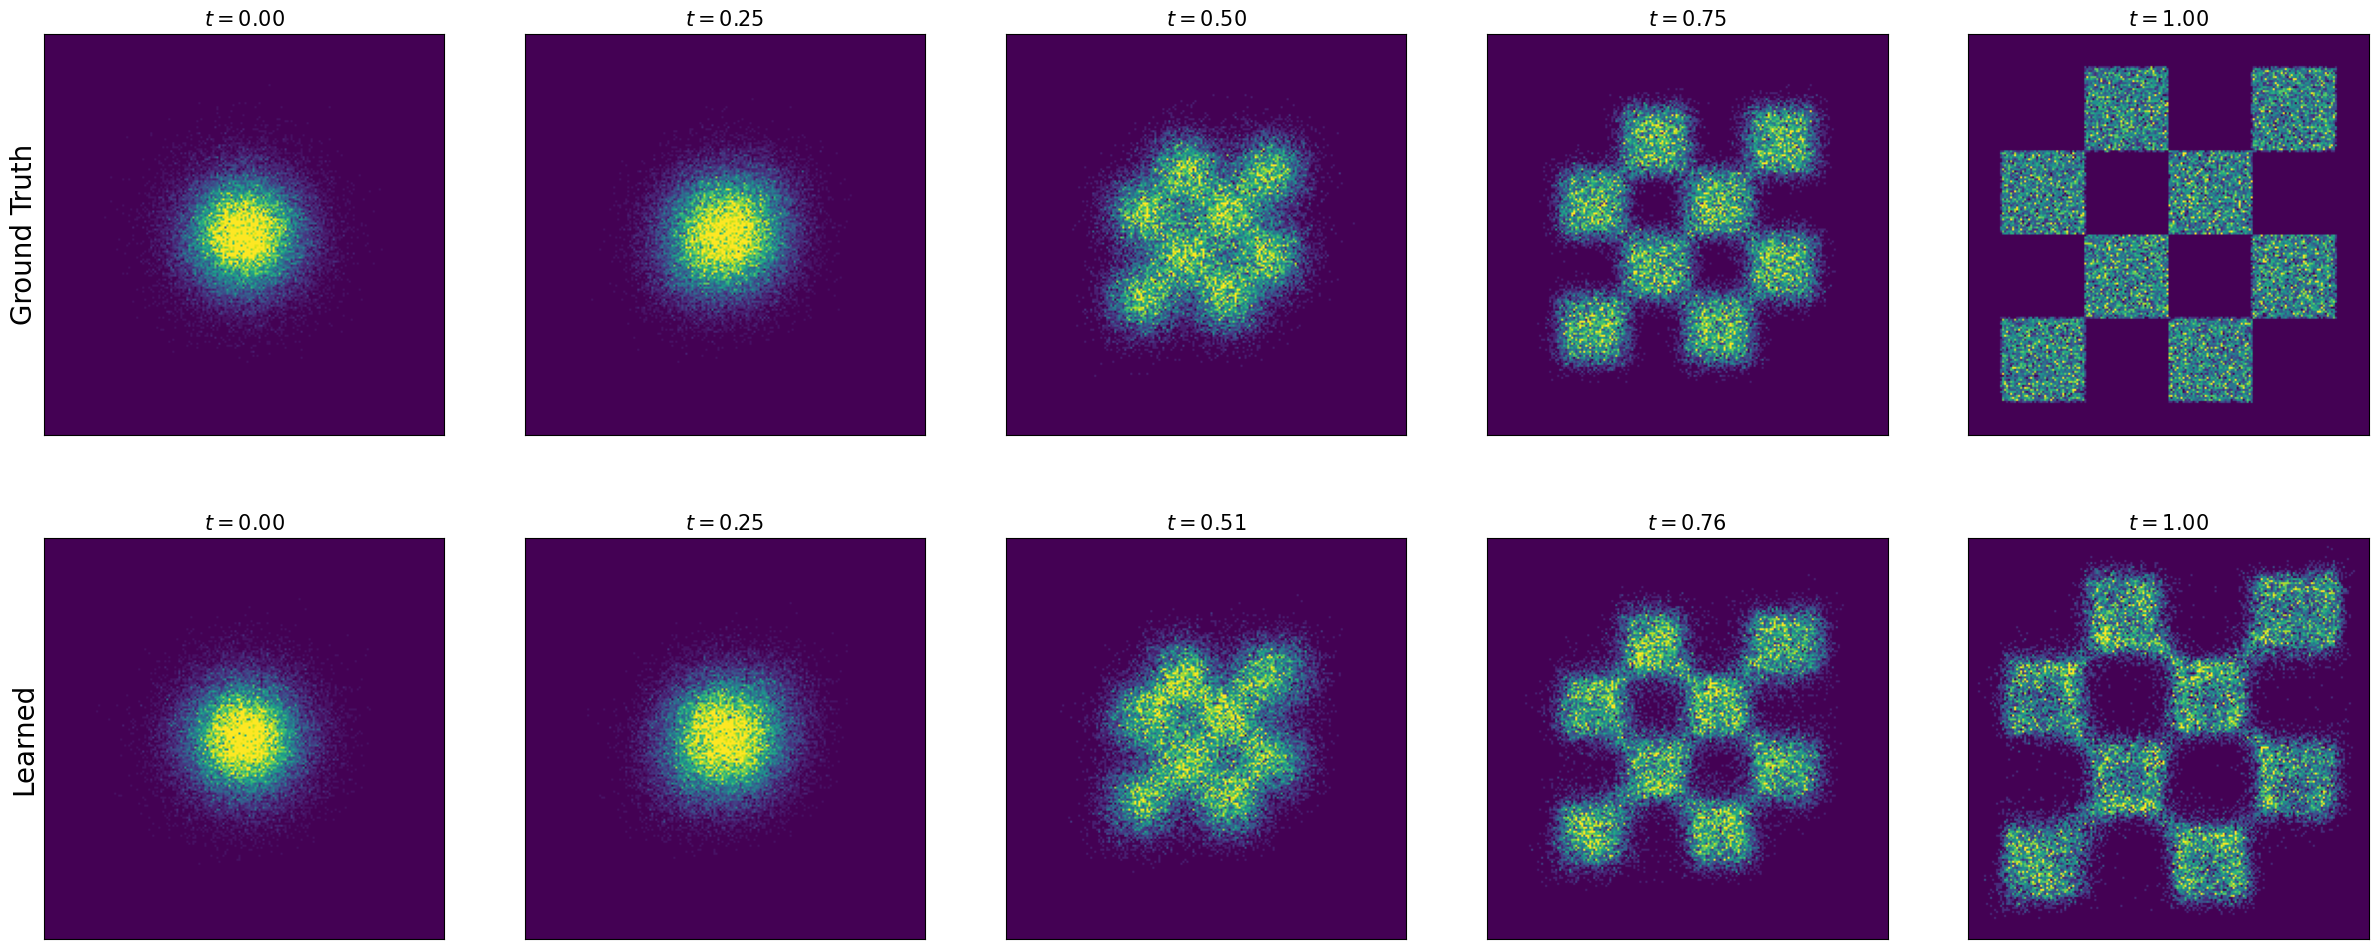

In [19]:
##########################
# Play around With These #
##########################
num_samples = 50000
num_marginals = 5

##############
# Setup Plots #
##############

fig, axes = plt.subplots(2, num_marginals, figsize=(6 * num_marginals, 6 * 2))
axes = axes.reshape(2, num_marginals)
scale = 6.0

###########################
# Graph Ground-Truth Marginals #
###########################
ts = torch.linspace(0.0, 1.0, num_marginals).to(device)
for idx, t in enumerate(ts):
    tt = t.view(1,1).expand(num_samples,1)
    xts = path.sample_marginal_path(tt)
    hist2d_samples(samples=xts.cpu(), ax=axes[0, idx], bins=200, scale=scale, percentile=99, alpha=1.0)
    axes[0, idx].set_xlim(-scale, scale)
    axes[0, idx].set_ylim(-scale, scale)
    axes[0, idx].set_xticks([])
    axes[0, idx].set_yticks([])
    axes[0, idx].set_title(f'$t={t.item():.2f}$', fontsize=15)
axes[0, 0].set_ylabel("Ground Truth", fontsize=20)

###############################################
# Graph Marginals of Learned Vector Field #
###############################################
ode = LearnedVectorFieldODE(linear_flow_model)
simulator = EulerSimulator(ode)
ts = torch.linspace(0,1,100).to(device)
record_every_idxs = record_every(len(ts), len(ts) // (num_marginals - 1))
x0 = path.p_simple.sample(num_samples)
xts = simulator.simulate_with_trajectory(x0, ts.view(1,-1,1).expand(num_samples,-1,1))
xts = xts[:,record_every_idxs,:]
for idx in range(xts.shape[1]):
    xx = xts[:,idx,:]
    hist2d_samples(samples=xx.cpu(), ax=axes[1, idx], bins=200, scale=scale, percentile=99, alpha=1.0)
    axes[1, idx].set_xlim(-scale, scale)
    axes[1, idx].set_ylim(-scale, scale)
    axes[1, idx].set_xticks([])
    axes[1, idx].set_yticks([])
    tt = ts[record_every_idxs[idx]]
    axes[1, idx].set_title(f'$t={tt.item():.2f}$', fontsize=15)
axes[1, 0].set_ylabel("Learned", fontsize=20)

plt.show()